## Email Name: Model Evaluation

This notebook evaluates the test data against the `Mistral-7B` finetuned model

### Setup

In [2]:
import sagemaker
import boto3
sess = sagemaker.Session()

sagemaker_session_bucket='sagemaker-sigparser-caylent-mlops'
if sagemaker_session_bucket is None and sess is not None:
    sagemaker_session_bucket = sess.default_bucket()

try:
    role = sagemaker.get_execution_role()
except ValueError:
    iam = boto3.client('iam')
    role = iam.get_role(RoleName='sagemaker_execution_role')['Role']['Arn']

sess = sagemaker.Session(default_bucket=sagemaker_session_bucket)

print(f"sagemaker role arn: {role}")
print(f"sagemaker session region: {sess.boto_region_name}")
print(f"sagemaker default bucket: {sess.default_bucket()}")

sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /root/.config/sagemaker/config.yaml
sagemaker role arn: arn:aws:iam::818442660361:role/service-role/AmazonSageMaker-ExecutionRole-20231103T203000
sagemaker session region: us-east-1
sagemaker default bucket: sagemaker-sigparser-caylent-mlops


In [23]:
from concurrent.futures import ThreadPoolExecutor
from tqdm import tqdm
import pandas as pd
import sys
import datetime
sys.path.append('..')
from utils.metrics import Evaluate
from utils.utils import Mistral_7B_V1
from prompts.email_names_v2 import prompt_email_names
from utils.s3_helper import read_s3_csv_to_dataframe, upload_dataframe_to_s3, upload_data_to_s3

###  Load Test Data

In [4]:
s3_input_prefix = 'data/email-names/input/processed'
data_timestamp = '2024-03-26'
file_name = f'{data_timestamp}_test.csv'

s3_data_path = f"{s3_input_prefix}/{file_name}"

10k records to evaluate performance

In [5]:
s3_input_prefix = 'data/email-names/input/raw'
data_timestamp = '2024-04-02'
file_name = 'sp_llm_emailname_inf-test_apr2.csv'

s3_data_path = f"{s3_input_prefix}/{file_name}"

In [6]:
test_df = read_s3_csv_to_dataframe(sess.default_bucket(), s3_data_path)

test_df.shape

(10000, 8)

In [7]:
test_df.head()

,Test Group,Email Address,Display Name,First Name,Middle Name,Last Name,Name Prefix,Name Suffix
0,INF-TEST-A,a_desai@openbook.works,"Desai, Aditi",Aditi,NaN,Desai,NaN,NaN
1,INF-TEST-A,a_elliott@outcast-clothing.com,"Elliott, Alan",Alan,NaN,Elliott,NaN,NaN
2,INF-TEST-A,a_foster@markconsults.com,ANTOINE FOSTER,Antoine,NaN,Foster,NaN,NaN
3,INF-TEST-A,a_harrington@optilogic.com,HARRINGTON Aditya,Aditya,NaN,Harrington,NaN,NaN
4,INF-TEST-A,a_howard@cbtcompanyinc.com,HOWARD Anne,Anne,NaN,Howard,NaN,NaN


#### Configure & Preprocess Test Data

In [8]:
#record_count = len(test_df)
record_count = 100
temp_test_data = ""
temp_test_data = test_df.head(record_count).copy()
temp_test_data.iloc[0]

Test Group                   INF-TEST-A
Email Address    a_desai@openbook.works
Display Name               Desai, Aditi
First Name                        Aditi
Middle Name                         NaN
Last Name                         Desai
Name Prefix                         NaN
Name Suffix                         NaN
Name: 0, dtype: object

In [9]:
temp_test_data.shape

(100, 8)

In [10]:
temp_test_data.head()

,Test Group,Email Address,Display Name,First Name,Middle Name,Last Name,Name Prefix,Name Suffix
0,INF-TEST-A,a_desai@openbook.works,"Desai, Aditi",Aditi,NaN,Desai,NaN,NaN
1,INF-TEST-A,a_elliott@outcast-clothing.com,"Elliott, Alan",Alan,NaN,Elliott,NaN,NaN
2,INF-TEST-A,a_foster@markconsults.com,ANTOINE FOSTER,Antoine,NaN,Foster,NaN,NaN
3,INF-TEST-A,a_harrington@optilogic.com,HARRINGTON Aditya,Aditya,NaN,Harrington,NaN,NaN
4,INF-TEST-A,a_howard@cbtcompanyinc.com,HOWARD Anne,Anne,NaN,Howard,NaN,NaN


In [11]:
# finding how many NaN values are there in each column
nan_count_per_column = temp_test_data.isna().sum()

print(f"NaN count per column: {nan_count_per_column}")

NaN count per column: Test Group        0
Email Address     0
Display Name      0
First Name        0
Middle Name      89
Last Name         0
Name Prefix      96
Name Suffix      95
dtype: int64


In [12]:
temp_test_data.fillna("", inplace=True)

print(f"NaN count per column after replacement: {temp_test_data.isna().sum()}")

NaN count per column after replacement: Test Group       0
Email Address    0
Display Name     0
First Name       0
Middle Name      0
Last Name        0
Name Prefix      0
Name Suffix      0
dtype: int64


In [13]:
temp_test_data.head()

,Test Group,Email Address,Display Name,First Name,Middle Name,Last Name,Name Prefix,Name Suffix
0,INF-TEST-A,a_desai@openbook.works,"Desai, Aditi",Aditi,,Desai,,
1,INF-TEST-A,a_elliott@outcast-clothing.com,"Elliott, Alan",Alan,,Elliott,,
2,INF-TEST-A,a_foster@markconsults.com,ANTOINE FOSTER,Antoine,,Foster,,
3,INF-TEST-A,a_harrington@optilogic.com,HARRINGTON Aditya,Aditya,,Harrington,,
4,INF-TEST-A,a_howard@cbtcompanyinc.com,HOWARD Anne,Anne,,Howard,,


In [14]:
# cols to check for empty string distribution
columns_to_check = ['First Name', 'Middle Name', 'Last Name', 'Name Prefix', 'Name Suffix']

# calculate the distribution (%) of empty strings "" in specified columns
empty_string_distribution = temp_test_data[columns_to_check].map(lambda x: x == "").mean() * 100

print("Distribution (%) of empty strings in specified columns:")
print(empty_string_distribution)

Distribution (%) of empty strings in specified columns:
First Name      0.0
Middle Name    89.0
Last Name       0.0
Name Prefix    96.0
Name Suffix    95.0
dtype: float64


#### Configure Prompt

In [15]:
system_prompt = prompt_email_names["system_prompt"]
instruction = prompt_email_names["instruction"]
prompt_version = prompt_email_names["prompt_version"]
prompt_type = prompt_email_names["prompt_type"]
print(f'prompt_version: {prompt_version}')

prompt_version: version-2-Ryan


#### Prepare the Test Inputs

In [16]:
def get_context(email_address, display_name):
    email_address = email_address.strip()
    display_name = display_name.strip()
    
    context_input_str = f"""Input:"""
    context_data = f"""{{"Email Address": "{email_address}", "Display Name": "{display_name}"}}"""
    context = context_input_str.strip() + context_data.strip()
    
    return context


contexts = temp_test_data.apply(lambda x: get_context(x['Email Address'], x['Display Name']), axis=1)

In [17]:
# sanity check
contexts[0]

'Input:{"Email Address": "a_desai@openbook.works", "Display Name": "Desai, Aditi"}'

### Prepare the Prompts for Test Data

In [18]:
prompt_df = pd.DataFrame({'system_prompt':system_prompt,
                         'instruction':instruction,
                          'context': contexts,
                         'prompt_type':prompt_type
                        })
prompt_df.head()

,system_prompt,instruction,context,prompt_type
0,You are a highly skilled assistant specializin...,Please extract the email name components from ...,"Input:{""Email Address"": ""a_desai@openbook.work...",email-names
1,You are a highly skilled assistant specializin...,Please extract the email name components from ...,"Input:{""Email Address"": ""a_elliott@outcast-clo...",email-names
2,You are a highly skilled assistant specializin...,Please extract the email name components from ...,"Input:{""Email Address"": ""a_foster@markconsults...",email-names
3,You are a highly skilled assistant specializin...,Please extract the email name components from ...,"Input:{""Email Address"": ""a_harrington@optilogi...",email-names
4,You are a highly skilled assistant specializin...,Please extract the email name components from ...,"Input:{""Email Address"": ""a_howard@cbtcompanyin...",email-names


In [19]:
# sanity check system prompt
print(prompt_df.iloc[0]['system_prompt'])

You are a highly skilled assistant specializing in data extraction. Your current task is to analyze the 'Email Address' and 'Display Name' fields to extract the 'First Name', 'Middle Name', 'Last Name', 'Name Prefix', and 'Name Suffix'.

Please respond strictly with this JSON format:
{
  "First Name": "xxx", 
  "Middle Name": "xxx", 
  "Last Name": "xxx", 
  "Name Prefix": "xxx", 
  "Name Suffix": "xxx"
}

where 'xxx' should be replaced with the corresponding name component extracted from the 'Email Address' or 'Display Name' fields. If a component is not present, leave the value as an empty string "".

Name components are generally extracted from the 'Display Name' field, however, reviewing the 'Email Address' field can give additional information into the correct extraction of the 'First Name', 'Middle Name', and 'Last Name' fields.

The 'Display Name' field can include extra terms like business names, job codes, locations, email addresses, and more. All of these extra terms should b

In [20]:
# sanity check instruction
print(prompt_df.iloc[0]['instruction'])

Please extract the email name components from the following input. All output must be in valid JSON. Don’t add explanation beyond the JSON.


### Initialize Model Endpoint

In [22]:
# setup endpoint config
endpoint_name = 'mistral-7b-email-name-finetuned'
model = "Mistral-7B"
model_version = "2.3.0"
model_id = "huggingface-llm-mistral-7b"

In [23]:
# endpoint
mistral = Mistral_7B_V1(endpoint_name=endpoint_name)

### Invoke Model and Get Results

In [24]:
%%time
results = ""
with ThreadPoolExecutor() as executor:
    results = list(tqdm(executor.map(mistral.get_email_name_results, prompt_df.iterrows()), total=len(prompt_df)))

  1%|          | 1/100 [00:04<07:42,  4.68s/it]

Function 'query_mistral_endpoint' took 4.78855 seconds to execute.
Function 'check_email_names_2' took 0.00070 seconds to execute.
Function 'extract_results' took 0.00074 seconds to execute.
Function 'get_email_name_results' took 4.78968 seconds to execute.
Function 'query_mistral_endpoint' took 4.77979 seconds to execute.
Function 'check_email_names_2' took 0.00002 seconds to execute.
Function 'extract_results' took 0.00004 seconds to execute.
Function 'get_email_name_results' took 4.77996 seconds to execute.
Function 'query_mistral_endpoint' took 4.77610 seconds to execute.
Function 'check_email_names_2' took 0.00039 seconds to execute.
Function 'extract_results' took 0.00044 seconds to execute.
Function 'get_email_name_results' took 4.77682 seconds to execute.
Function 'query_mistral_endpoint' took 4.76481 seconds to execute.
Function 'check_email_names_2' took 0.00001 seconds to execute.
Function 'extract_results' took 0.00002 seconds to execute.
Function 'get_email_name_results' t

  7%|▋         | 7/100 [00:09<01:49,  1.18s/it]

Function 'query_mistral_endpoint' took 4.63115 seconds to execute.
Function 'check_email_names_2' took 0.00009 seconds to execute.
Function 'extract_results' took 0.00013 seconds to execute.
Function 'get_email_name_results' took 4.63357 seconds to execute.
Function 'query_mistral_endpoint' took 4.64105 seconds to execute.
Function 'check_email_names_2' took 0.00002 seconds to execute.
Function 'extract_results' took 0.00003 seconds to execute.
Function 'get_email_name_results' took 4.64122 seconds to execute.
Function 'query_mistral_endpoint' took 4.63775 seconds to execute.
Function 'check_email_names_2' took 0.00002 seconds to execute.
Function 'extract_results' took 0.00003 seconds to execute.
Function 'get_email_name_results' took 4.63790 seconds to execute.
Function 'query_mistral_endpoint' took 4.64565 seconds to execute.
Function 'check_email_names_2' took 0.00002 seconds to execute.
Function 'extract_results' took 0.00003 seconds to execute.
Function 'get_email_name_results' t

 13%|█▎        | 13/100 [00:13<01:22,  1.05it/s]

Function 'query_mistral_endpoint' took 4.63230 seconds to execute.
Function 'check_email_names_2' took 0.00003 seconds to execute.
Function 'extract_results' took 0.00005 seconds to execute.
Function 'get_email_name_results' took 4.63283 seconds to execute.
Function 'query_mistral_endpoint' took 4.62391 seconds to execute.
Function 'check_email_names_2' took 0.00002 seconds to execute.
Function 'extract_results' took 0.00003 seconds to execute.
Function 'get_email_name_results' took 4.62406 seconds to execute.
Function 'query_mistral_endpoint' took 4.63405 seconds to execute.
Function 'check_email_names_2' took 0.00002 seconds to execute.
Function 'extract_results' took 0.00003 seconds to execute.
Function 'get_email_name_results' took 4.63417 seconds to execute.
Function 'query_mistral_endpoint' took 4.63578 seconds to execute.
Function 'check_email_names_2' took 0.00002 seconds to execute.
Function 'extract_results' took 0.00003 seconds to execute.
Function 'get_email_name_results' t

 19%|█▉        | 19/100 [00:18<01:10,  1.15it/s]

Function 'query_mistral_endpoint' took 4.62957 seconds to execute.
Function 'check_email_names_2' took 0.00002 seconds to execute.
Function 'extract_results' took 0.00007 seconds to execute.
Function 'get_email_name_results' took 4.62981 seconds to execute.
Function 'query_mistral_endpoint' took 4.64215 seconds to execute.
Function 'check_email_names_2' took 0.00002 seconds to execute.
Function 'extract_results' took 0.00003 seconds to execute.
Function 'get_email_name_results' took 4.64230 seconds to execute.
Function 'query_mistral_endpoint' took 4.63675 seconds to execute.
Function 'check_email_names_2' took 0.00002 seconds to execute.
Function 'extract_results' took 0.00003 seconds to execute.
Function 'get_email_name_results' took 4.63691 seconds to execute.
Function 'query_mistral_endpoint' took 4.63717 seconds to execute.
Function 'check_email_names_2' took 0.00002 seconds to execute.
Function 'extract_results' took 0.00003 seconds to execute.
Function 'get_email_name_results' t

 25%|██▌       | 25/100 [00:23<01:02,  1.20it/s]

Function 'query_mistral_endpoint' took 4.63005 seconds to execute.
Function 'check_email_names_2' took 0.00003 seconds to execute.
Function 'extract_results' took 0.00004 seconds to execute.
Function 'get_email_name_results' took 4.63028 seconds to execute.
Function 'query_mistral_endpoint' took 4.63310 seconds to execute.
Function 'check_email_names_2' took 0.00002 seconds to execute.
Function 'extract_results' took 0.00003 seconds to execute.
Function 'get_email_name_results' took 4.63329 seconds to execute.
Function 'query_mistral_endpoint' took 4.62777 seconds to execute.
Function 'check_email_names_2' took 0.00001 seconds to execute.
Function 'extract_results' took 0.00003 seconds to execute.
Function 'get_email_name_results' took 4.62789 seconds to execute.
Function 'query_mistral_endpoint' took 4.63817 seconds to execute.
Function 'check_email_names_2' took 0.00002 seconds to execute.
Function 'extract_results' took 0.00004 seconds to execute.
Function 'get_email_name_results' t

 31%|███       | 31/100 [00:27<00:56,  1.23it/s]

Function 'query_mistral_endpoint' took 4.65926 seconds to execute.
Function 'check_email_names_2' took 0.00002 seconds to execute.
Function 'extract_results' took 0.00004 seconds to execute.
Function 'get_email_name_results' took 4.65949 seconds to execute.
Function 'query_mistral_endpoint' took 4.65763 seconds to execute.
Function 'check_email_names_2' took 0.00002 seconds to execute.
Function 'extract_results' took 0.00003 seconds to execute.
Function 'get_email_name_results' took 4.65777 seconds to execute.
Function 'query_mistral_endpoint' took 4.64763 seconds to execute.
Function 'check_email_names_2' took 0.00002 seconds to execute.
Function 'extract_results' took 0.00003 seconds to execute.
Function 'get_email_name_results' took 4.64777 seconds to execute.
Function 'query_mistral_endpoint' took 4.65181 seconds to execute.
Function 'check_email_names_2' took 0.00001 seconds to execute.
Function 'extract_results' took 0.00003 seconds to execute.
Function 'get_email_name_results' t

 37%|███▋      | 37/100 [00:32<00:50,  1.25it/s]

Function 'query_mistral_endpoint' took 4.63469 seconds to execute.
Function 'check_email_names_2' took 0.00003 seconds to execute.
Function 'extract_results' took 0.00005 seconds to execute.
Function 'get_email_name_results' took 4.63501 seconds to execute.
Function 'query_mistral_endpoint' took 4.62401 seconds to execute.
Function 'check_email_names_2' took 0.00002 seconds to execute.
Function 'extract_results' took 0.00003 seconds to execute.
Function 'get_email_name_results' took 4.62415 seconds to execute.
Function 'query_mistral_endpoint' took 4.64351 seconds to execute.
Function 'check_email_names_2' took 0.00002 seconds to execute.
Function 'extract_results' took 0.00003 seconds to execute.
Function 'get_email_name_results' took 4.64367 seconds to execute.
Function 'query_mistral_endpoint' took 4.64268 seconds to execute.
Function 'check_email_names_2' took 0.00002 seconds to execute.
Function 'extract_results' took 0.00008 seconds to execute.
Function 'get_email_name_results' t

 43%|████▎     | 43/100 [00:37<00:45,  1.26it/s]

Function 'query_mistral_endpoint' took 4.60879 seconds to execute.
Function 'check_email_names_2' took 0.00002 seconds to execute.
Function 'extract_results' took 0.00004 seconds to execute.
Function 'get_email_name_results' took 4.60923 seconds to execute.
Function 'query_mistral_endpoint' took 4.63206 seconds to execute.
Function 'check_email_names_2' took 0.00001 seconds to execute.
Function 'extract_results' took 0.00003 seconds to execute.
Function 'get_email_name_results' took 4.63220 seconds to execute.
Function 'query_mistral_endpoint' took 4.61853 seconds to execute.
Function 'check_email_names_2' took 0.00002 seconds to execute.
Function 'extract_results' took 0.00003 seconds to execute.
Function 'get_email_name_results' took 4.61866 seconds to execute.
Function 'query_mistral_endpoint' took 4.63167 seconds to execute.
Function 'check_email_names_2' took 0.00002 seconds to execute.
Function 'extract_results' took 0.00008 seconds to execute.
Function 'get_email_name_results' t

 49%|████▉     | 49/100 [00:41<00:40,  1.27it/s]

Function 'query_mistral_endpoint' took 4.60886 seconds to execute.
Function 'check_email_names_2' took 0.00002 seconds to execute.
Function 'extract_results' took 0.00003 seconds to execute.
Function 'get_email_name_results' took 4.60919 seconds to execute.
Function 'query_mistral_endpoint' took 4.62997 seconds to execute.
Function 'check_email_names_2' took 0.00001 seconds to execute.
Function 'extract_results' took 0.00003 seconds to execute.
Function 'get_email_name_results' took 4.63010 seconds to execute.
Function 'query_mistral_endpoint' took 4.61467 seconds to execute.
Function 'check_email_names_2' took 0.00001 seconds to execute.
Function 'extract_results' took 0.00003 seconds to execute.
Function 'get_email_name_results' took 4.61482 seconds to execute.
Function 'query_mistral_endpoint' took 4.61927 seconds to execute.
Function 'check_email_names_2' took 0.00001 seconds to execute.
Function 'extract_results' took 0.00002 seconds to execute.
Function 'get_email_name_results' t

 55%|█████▌    | 55/100 [00:46<00:35,  1.28it/s]

Function 'query_mistral_endpoint' took 4.63372 seconds to execute.
Function 'check_email_names_2' took 0.00002 seconds to execute.
Function 'extract_results' took 0.00005 seconds to execute.
Function 'get_email_name_results' took 4.63440 seconds to execute.
Function 'query_mistral_endpoint' took 4.63049 seconds to execute.
Function 'check_email_names_2' took 0.00002 seconds to execute.
Function 'extract_results' took 0.00003 seconds to execute.
Function 'get_email_name_results' took 4.63062 seconds to execute.
Function 'query_mistral_endpoint' took 4.63029 seconds to execute.
Function 'check_email_names_2' took 0.00001 seconds to execute.
Function 'extract_results' took 0.00002 seconds to execute.
Function 'get_email_name_results' took 4.63041 seconds to execute.
Function 'query_mistral_endpoint' took 4.64077 seconds to execute.
Function 'check_email_names_2' took 0.00001 seconds to execute.
Function 'extract_results' took 0.00003 seconds to execute.
Function 'get_email_name_results' t

 61%|██████    | 61/100 [00:51<00:30,  1.28it/s]

Function 'query_mistral_endpoint' took 4.64172 seconds to execute.
Function 'check_email_names_2' took 0.00003 seconds to execute.
Function 'extract_results' took 0.00004 seconds to execute.
Function 'get_email_name_results' took 4.64208 seconds to execute.
Function 'query_mistral_endpoint' took 4.63568 seconds to execute.
Function 'check_email_names_2' took 0.00003 seconds to execute.
Function 'extract_results' took 0.00005 seconds to execute.
Function 'get_email_name_results' took 4.63587 seconds to execute.
Function 'query_mistral_endpoint' took 4.64579 seconds to execute.
Function 'check_email_names_2' took 0.00002 seconds to execute.
Function 'extract_results' took 0.00004 seconds to execute.
Function 'get_email_name_results' took 4.64595 seconds to execute.
Function 'query_mistral_endpoint' took 4.65055 seconds to execute.
Function 'check_email_names_2' took 0.00002 seconds to execute.
Function 'extract_results' took 0.00005 seconds to execute.
Function 'get_email_name_results' t

 67%|██████▋   | 67/100 [00:55<00:25,  1.29it/s]

Function 'query_mistral_endpoint' took 4.63942 seconds to execute.
Function 'check_email_names_2' took 0.00003 seconds to execute.
Function 'extract_results' took 0.00005 seconds to execute.
Function 'get_email_name_results' took 4.63964 seconds to execute.
Function 'query_mistral_endpoint' took 4.64917 seconds to execute.
Function 'check_email_names_2' took 0.00001 seconds to execute.
Function 'extract_results' took 0.00002 seconds to execute.
Function 'get_email_name_results' took 4.64932 seconds to execute.
Function 'query_mistral_endpoint' took 4.66466 seconds to execute.
Function 'check_email_names_2' took 0.00002 seconds to execute.
Function 'extract_results' took 0.00004 seconds to execute.
Function 'get_email_name_results' took 4.66484 seconds to execute.
Function 'query_mistral_endpoint' took 4.66285 seconds to execute.
Function 'check_email_names_2' took 0.00002 seconds to execute.
Function 'extract_results' took 0.00003 seconds to execute.
Function 'get_email_name_results' t

 73%|███████▎  | 73/100 [01:00<00:20,  1.29it/s]

Function 'query_mistral_endpoint' took 4.66019 seconds to execute.
Function 'check_email_names_2' took 0.00003 seconds to execute.
Function 'extract_results' took 0.00021 seconds to execute.
Function 'get_email_name_results' took 4.66059 seconds to execute.
Function 'query_mistral_endpoint' took 4.65390 seconds to execute.
Function 'check_email_names_2' took 0.00002 seconds to execute.
Function 'extract_results' took 0.00003 seconds to execute.
Function 'get_email_name_results' took 4.65403 seconds to execute.
Function 'query_mistral_endpoint' took 4.66498 seconds to execute.
Function 'check_email_names_2' took 0.00001 seconds to execute.
Function 'extract_results' took 0.00003 seconds to execute.
Function 'get_email_name_results' took 4.66510 seconds to execute.
Function 'query_mistral_endpoint' took 4.64825 seconds to execute.
Function 'check_email_names_2' took 0.00001 seconds to execute.
Function 'extract_results' took 0.00003 seconds to execute.
Function 'get_email_name_results' t

 79%|███████▉  | 79/100 [01:05<00:16,  1.29it/s]

Function 'query_mistral_endpoint' took 4.62894 seconds to execute.Function 'query_mistral_endpoint' took 4.64108 seconds to execute.
Function 'check_email_names_2' took 0.00002 seconds to execute.
Function 'extract_results' took 0.00003 seconds to execute.
Function 'get_email_name_results' took 4.64123 seconds to execute.
Function 'query_mistral_endpoint' took 4.63940 seconds to execute.
Function 'check_email_names_2' took 0.00002 seconds to execute.
Function 'extract_results' took 0.00004 seconds to execute.
Function 'get_email_name_results' took 4.63960 seconds to execute.

Function 'check_email_names_2' took 0.00002 seconds to execute.
Function 'extract_results' took 0.00003 seconds to execute.
Function 'get_email_name_results' took 4.63243 seconds to execute.
Function 'query_mistral_endpoint' took 4.63537 seconds to execute.
Function 'check_email_names_2' took 0.00001 seconds to execute.
Function 'extract_results' took 0.00002 seconds to execute.
Function 'get_email_name_results' t

 85%|████████▌ | 85/100 [01:09<00:11,  1.29it/s]

Function 'query_mistral_endpoint' took 4.62958 seconds to execute.
Function 'check_email_names_2' took 0.00003 seconds to execute.
Function 'extract_results' took 0.00006 seconds to execute.
Function 'get_email_name_results' took 4.62980 seconds to execute.
Function 'query_mistral_endpoint' took 4.63722 seconds to execute.
Function 'check_email_names_2' took 0.00001 seconds to execute.
Function 'extract_results' took 0.00003 seconds to execute.
Function 'get_email_name_results' took 4.63736 seconds to execute.
Function 'query_mistral_endpoint' took 4.63405 seconds to execute.
Function 'check_email_names_2' took 0.00001 seconds to execute.
Function 'extract_results' took 0.00003 seconds to execute.
Function 'get_email_name_results' took 4.63416 seconds to execute.
Function 'query_mistral_endpoint' took 4.64227 seconds to execute.
Function 'check_email_names_2' took 0.00001 seconds to execute.
Function 'extract_results' took 0.00003 seconds to execute.
Function 'get_email_name_results' t

 91%|█████████ | 91/100 [01:14<00:06,  1.29it/s]

Function 'query_mistral_endpoint' took 4.63281 seconds to execute.
Function 'check_email_names_2' took 0.00003 seconds to execute.
Function 'extract_results' took 0.00006 seconds to execute.
Function 'get_email_name_results' took 4.63327 seconds to execute.
Function 'query_mistral_endpoint' took 4.62722 seconds to execute.
Function 'check_email_names_2' took 0.00002 seconds to execute.
Function 'extract_results' took 0.00003 seconds to execute.
Function 'get_email_name_results' took 4.62734 seconds to execute.
Function 'query_mistral_endpoint' took 4.64111 seconds to execute.
Function 'check_email_names_2' took 0.00002 seconds to execute.
Function 'extract_results' took 0.00003 seconds to execute.
Function 'get_email_name_results' took 4.64124 seconds to execute.
Function 'query_mistral_endpoint' took 4.63444 seconds to execute.
Function 'check_email_names_2' took 0.00001 seconds to execute.
Function 'extract_results' took 0.00003 seconds to execute.
Function 'get_email_name_results' t

100%|██████████| 100/100 [01:18<00:00,  1.27it/s]

Function 'query_mistral_endpoint' took 4.24783 seconds to execute.
Function 'check_email_names_2' took 0.00002 seconds to execute.
Function 'extract_results' took 0.00004 seconds to execute.
Function 'get_email_name_results' took 4.24844 seconds to execute.
Function 'query_mistral_endpoint' took 4.25327 seconds to execute.
Function 'check_email_names_2' took 0.00001 seconds to execute.
Function 'extract_results' took 0.00002 seconds to execute.
Function 'get_email_name_results' took 4.25343 seconds to execute.
Function 'query_mistral_endpoint' took 4.24970 seconds to execute.
Function 'check_email_names_2' took 0.00001 seconds to execute.
Function 'extract_results' took 0.00002 seconds to execute.
Function 'get_email_name_results' took 4.24980 seconds to execute.
Function 'query_mistral_endpoint' took 4.25246 seconds to execute.
Function 'check_email_names_2' took 0.00002 seconds to execute.
Function 'extract_results' took 0.00003 seconds to execute.
Function 'get_email_name_results' t

In [25]:
results[0]

{'First Name': 'Aditi',
 'Middle Name': '',
 'Last Name': 'Desai',
 'Name Prefix': '',
 'Name Suffix': '',
 'Remarks': None}

In [26]:
len(results)

100

### Results Processing

In [27]:
# extracting each attribute into separate lists
p_fname = [names['First Name'] for names in results]
p_midname = [names['Middle Name'] for names in results]
p_lname = [names['Last Name'] for names in results]
p_nprefix = [names['Name Prefix'] for names in results]
p_nsuffix = [names['Name Suffix'] for names in results]
remarks = [names['Remarks'] for names in results]

# assign new columns to the dataframe
temp_test_data['p_fname'] = p_fname
temp_test_data['p_midname'] = p_midname
temp_test_data['p_lname'] = p_lname
temp_test_data['p_nprefix'] = p_nprefix
temp_test_data['p_nsuffix'] = p_nsuffix
temp_test_data['remarks'] = remarks

In [28]:
temp_test_data.head()

,Test Group,Email Address,Display Name,First Name,Middle Name,Last Name,Name Prefix,Name Suffix,p_fname,p_midname,p_lname,p_nprefix,p_nsuffix,remarks
0,INF-TEST-A,a_desai@openbook.works,"Desai, Aditi",Aditi,,Desai,,,Aditi,,Desai,,,None
1,INF-TEST-A,a_elliott@outcast-clothing.com,"Elliott, Alan",Alan,,Elliott,,,Alan,,Elliott,,,None
2,INF-TEST-A,a_foster@markconsults.com,ANTOINE FOSTER,Antoine,,Foster,,,Antoine,,Foster,,,None
3,INF-TEST-A,a_harrington@optilogic.com,HARRINGTON Aditya,Aditya,,Harrington,,,Aditya,,Harrington,,,None
4,INF-TEST-A,a_howard@cbtcompanyinc.com,HOWARD Anne,Anne,,Howard,,,Anne,,Howard,,,None


### Calculate Metrics

#### Jaccard Index

In [29]:
jaccard_fname = Evaluate().compute_jaccard_score(temp_test_data['p_fname'].str.lower().str.strip(), temp_test_data['First Name'].str.lower().str.strip())
temp_test_data['jaccard_fname'] = jaccard_fname

jaccard_midname = Evaluate().compute_jaccard_score(temp_test_data['p_midname'].str.lower().str.strip(), temp_test_data['Middle Name'].str.lower().str.strip())
temp_test_data['jaccard_midname'] = jaccard_midname

jaccard_lname = Evaluate().compute_jaccard_score(temp_test_data['p_lname'].str.lower().str.strip(), temp_test_data['Last Name'].str.lower().str.strip())
temp_test_data['jaccard_lname'] = jaccard_lname

jaccard_nprefix = Evaluate().compute_jaccard_score(temp_test_data['p_nprefix'].str.lower().str.strip(), temp_test_data['Name Prefix'].str.lower().str.strip())
temp_test_data['jaccard_nprefix'] = jaccard_nprefix

jaccard_nsuffix = Evaluate().compute_jaccard_score(temp_test_data['p_nsuffix'].str.lower().str.strip(), temp_test_data['Name Suffix'].str.lower().str.strip())
temp_test_data['jaccard_nsuffix'] = jaccard_nsuffix

temp_test_data.head()

,Test Group,Email Address,Display Name,First Name,Middle Name,Last Name,Name Prefix,Name Suffix,p_fname,p_midname,p_lname,p_nprefix,p_nsuffix,remarks,jaccard_fname,jaccard_midname,jaccard_lname,jaccard_nprefix,jaccard_nsuffix
0,INF-TEST-A,a_desai@openbook.works,"Desai, Aditi",Aditi,,Desai,,,Aditi,,Desai,,,None,1.0,1,1.0,1,1
1,INF-TEST-A,a_elliott@outcast-clothing.com,"Elliott, Alan",Alan,,Elliott,,,Alan,,Elliott,,,None,1.0,1,1.0,1,1
2,INF-TEST-A,a_foster@markconsults.com,ANTOINE FOSTER,Antoine,,Foster,,,Antoine,,Foster,,,None,1.0,1,1.0,1,1
3,INF-TEST-A,a_harrington@optilogic.com,HARRINGTON Aditya,Aditya,,Harrington,,,Aditya,,Harrington,,,None,1.0,1,1.0,1,1
4,INF-TEST-A,a_howard@cbtcompanyinc.com,HOWARD Anne,Anne,,Howard,,,Anne,,Howard,,,None,1.0,1,1.0,1,1


#### Pie Plot

In [30]:
import matplotlib.pyplot as plt

def plot_jaccard_similarity_pie_chart(jaccard_value_counts, entity_type):
    """
    Plots a pie chart for Jaccard similarity scores.
    """
    # plotting the value counts as a pie chart
    fig, ax = plt.subplots()
    jaccard_value_counts.plot(kind='pie', autopct='%1.1f%%', startangle=140, ax=ax, labels=None)
    plt.title(f'Proportion of Jaccard Similarity Scores for {entity_type}')
    plt.ylabel('')
    
    # adding legend
    labels = [f'{label}: {val:1.3f}' for label, val in jaccard_value_counts.items()]
    ax.legend(labels, title="Jaccard Similarity Scores", loc="center left", bbox_to_anchor=(1, 0.5))
    
    plt.show()

In [31]:
jaccard_fname_value_counts = temp_test_data['jaccard_fname'].value_counts(dropna=False, normalize=True).head()
jaccard_fname_value_counts

jaccard_fname
1.0    0.95
0.0    0.05
Name: proportion, dtype: float64

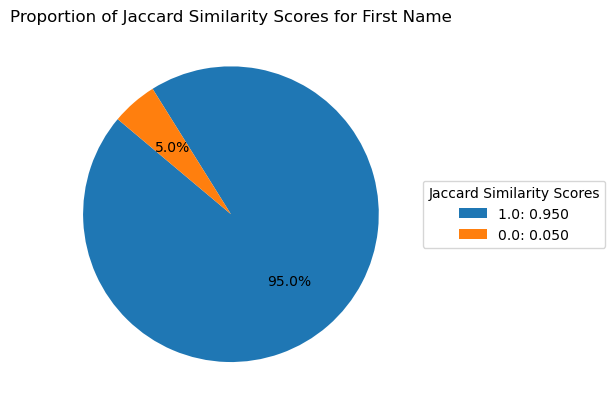

In [32]:
# plotting the value counts as a pie chart

plot_jaccard_similarity_pie_chart(jaccard_fname_value_counts, "First Name")

In [33]:
jaccard_midname_value_counts = temp_test_data['jaccard_midname'].value_counts(dropna=False, normalize=True).head()
jaccard_midname_value_counts

jaccard_midname
1    0.99
0    0.01
Name: proportion, dtype: float64

In [34]:
# filter the dataframe to include only rows where 'Middle Name' is not an empty string

filtered_midname_df = temp_test_data[temp_test_data['Middle Name'] != ""]
filtered_jaccard_midname_value_counts = filtered_midname_df['jaccard_midname'].value_counts(dropna=False, normalize=True).head()
filtered_jaccard_midname_value_counts

jaccard_midname
1    0.909091
0    0.090909
Name: proportion, dtype: float64

In [35]:
jaccard_lname_value_counts = temp_test_data['jaccard_lname'].value_counts(dropna=False, normalize=True).head()
jaccard_lname_value_counts

jaccard_lname
1.0    1.0
Name: proportion, dtype: float64

In [36]:
# filter the dataframe to include only rows where 'Last Name' is not an empty string

filtered_lname_df = temp_test_data[temp_test_data['Last Name'] != ""]
filtered_jaccard_lname_value_counts = filtered_lname_df['jaccard_lname'].value_counts(dropna=False, normalize=True).head()
filtered_jaccard_lname_value_counts

jaccard_lname
1.0    1.0
Name: proportion, dtype: float64

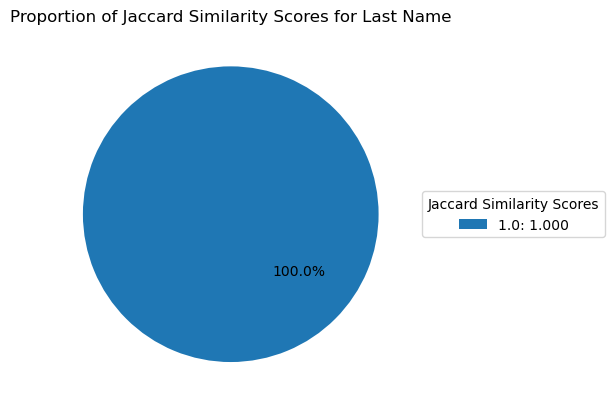

In [37]:
# plotting the value counts as a pie chart

plot_jaccard_similarity_pie_chart(jaccard_lname_value_counts, "Last Name")

In [38]:
jaccard_nprefix_value_counts = temp_test_data['jaccard_nprefix'].value_counts(dropna=False, normalize=True).head()
jaccard_nprefix_value_counts

jaccard_nprefix
1    1.0
Name: proportion, dtype: float64

In [39]:
# filter the dataframe to include only rows where 'Name Prefix' is not an empty string

filtered_nprefix_df = temp_test_data[temp_test_data['Name Prefix'] != ""]
filtered_jaccard_nprefix_value_counts = filtered_nprefix_df['jaccard_nprefix'].value_counts(dropna=False, normalize=True).head()
filtered_jaccard_nprefix_value_counts

jaccard_nprefix
1    1.0
Name: proportion, dtype: float64

In [40]:
jaccard_nsuffix_value_counts = temp_test_data['jaccard_nsuffix'].value_counts(dropna=False, normalize=True).head()
jaccard_nsuffix_value_counts

jaccard_nsuffix
1    0.99
0    0.01
Name: proportion, dtype: float64

In [41]:
# filter the dataframe to include only rows where 'Name Suffix' is not an empty string

filtered_nsuffix_df = temp_test_data[temp_test_data['Name Suffix'] != ""]
filtered_jaccard_nsuffix_value_counts = filtered_nsuffix_df['jaccard_nsuffix'].value_counts(dropna=False, normalize=True).head()
filtered_jaccard_nsuffix_value_counts

jaccard_nsuffix
1    0.8
0    0.2
Name: proportion, dtype: float64

In [42]:
jaccard_index = {'jaccard_fname': jaccard_fname_value_counts.to_dict(),
                 'jaccard_midname': jaccard_midname_value_counts.to_dict(),
                 'jaccard_lname': jaccard_lname_value_counts.to_dict(),
                 'jaccard_nprefix': jaccard_nprefix_value_counts.to_dict(),
                 'jaccard_nsuffix': jaccard_nsuffix_value_counts.to_dict()
                }

In [43]:
# Round off values to 3 decimal places
for key in jaccard_index:
    jaccard_index[key] = {k: round(v, 3) for k, v in jaccard_index[key].items()}

# pretty print
import pprint
pp = pprint.PrettyPrinter(indent=4)
pp.pprint(jaccard_index)

{   'jaccard_fname': {0.0: 0.05, 1.0: 0.95},
    'jaccard_lname': {1.0: 1.0},
    'jaccard_midname': {0: 0.01, 1: 0.99},
    'jaccard_nprefix': {1: 1.0},
    'jaccard_nsuffix': {0: 0.01, 1: 0.99}}


### Excluding Test Group `INF-TEST-B` per chat message

In [44]:
filtered_df = temp_test_data[temp_test_data['Test Group'] != 'INF-TEST-B']

jaccard_fname_value_counts = filtered_df['jaccard_fname'].value_counts(dropna=False, normalize=True).head()
print(jaccard_fname_value_counts)

filtered_midname_df = filtered_df[filtered_df['Middle Name'] != ""]
jaccard_midname_value_counts = filtered_midname_df['jaccard_midname'].value_counts(dropna=False, normalize=True).head()
print(jaccard_midname_value_counts)

filtered_lname_df = filtered_df[filtered_df['Last Name'] != ""]
jaccard_lname_value_counts = filtered_lname_df['jaccard_lname'].value_counts(dropna=False, normalize=True).head()
print(jaccard_lname_value_counts)

filtered_nprefix_df = filtered_df[filtered_df['Name Prefix'] != ""]
jaccard_nprefix_value_counts = filtered_nprefix_df['jaccard_nprefix'].value_counts(dropna=False, normalize=True).head()
print(jaccard_nprefix_value_counts)

filtered_nsuffix_df = filtered_df[filtered_df['Name Suffix'] != ""]
jaccard_nsuffix_value_counts = filtered_nsuffix_df['jaccard_nsuffix'].value_counts(dropna=False, normalize=True).head()
print(jaccard_nsuffix_value_counts)

jaccard_fname
1.0    0.95
0.0    0.05
Name: proportion, dtype: float64
jaccard_midname
1    0.909091
0    0.090909
Name: proportion, dtype: float64
jaccard_lname
1.0    1.0
Name: proportion, dtype: float64
jaccard_nprefix
1    1.0
Name: proportion, dtype: float64
jaccard_nsuffix
1    0.8
0    0.2
Name: proportion, dtype: float64


### Save Results to S3

In [46]:
timestamp = datetime.datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
s3_output_prefix = 'data/email-names/output'

object_name = f"{s3_output_prefix}/{model}/email_names_prediction_results_{timestamp}"

# create the file name as per the task: name-parse, email-signature
file_name = f"email_names_prediction_results_{timestamp}.csv"
upload_dataframe_to_s3(sess.default_bucket(), object_name, file_name, temp_test_data)

In [47]:
# save the results summary in s3

input_data_uri = r's3://{0}/{1}'.format(sess.default_bucket(), s3_data_path)
output_data_uri = r's3://{0}/{1}/{2}'.format(sess.default_bucket(), object_name, file_name)

results_summary = {
    "input_data": input_data_uri,
    "model_id": model_id,
    "model_version": model_version,
    "prompt_version": prompt_version,
    "system_prompt":system_prompt,
    "instruction": instruction,
    "output_data": output_data_uri,
    "jaccard_index": jaccard_index
}

upload_data_to_s3(results_summary, sess.default_bucket(), object_name)

Data upload successfull s3_uri:  s3://sagemaker-sigparser-caylent-mlops/data/email-names/output/Mistral-7B/email_names_prediction_results_2024-04-19_19-23-48/results_summary.json


True

### Error Analysis

In [48]:
# set option to display all rows
pd.set_option('display.max_rows', None)

# set option to display full column content
pd.set_option('display.max_colwidth', None)

#### First Name Analysis

In [49]:
# conditions for error records
cond1 = (temp_test_data['jaccard_fname']==0)
cond2 = (temp_test_data['First Name']=="")

# filter and view error records
fname_cols = ['Email Address', 'Display Name','First Name','p_fname','remarks','jaccard_fname']
temp_test_data.loc[cond1 & ~cond2, fname_cols]

,Email Address,Display Name,First Name,p_fname,remarks,jaccard_fname
13,a_richardson@marksmendaily.com,Anton Richardson,Anton,Antonio,None,0.0
16,a_sandberg@marstranslation.live,'a_sandberg@marstranslation.live',Anya,A,None,0.0
29,a.jensen@worldhydrogenleaders.com,'a.jensen@worldhydrogenleaders.com',Andrea,A.,None,0.0
51,abuck@assetstrategies.com,'abuck@assetstrategies.com',Arthur,Abuck,None,0.0
97,aferguson@agiloft.com,'aferguson@agiloft.com',Anne,Amber,None,0.0


##### Findings: First Name Analysis

**Mistral-7B Pretrained | Prompt version 2.0 (Ryan)**
The errors are related to the following scenarios:
- Model Response Error
  - Problem: the model is not able to extract `Last Name` in few samples.  Index [58, 774, 1183, etc.]
  - Potential Solution: although not guaranteed, we can look to engineer prompt to force the Model to generate a standard JSON response even though it means that some field values are empty. Note: this is already baked into the current prompt version.
- Insufficient Information
  - both `Email Address` and `Display Name` do not have first names. Index [83, 755, 898, etc.]
- Last Name as First Name
  - Model picks lastname in the `Display Name` as first name. Index [201, 248, 249, etc.]
  
**Mistral-7B Finetuned | Prompt version 2.0 (Ryan)**
The errors are related to the following scenarios:
- Insufficient Information
  - both `Email Address` and `Display Name` do not have first names. Index [83, 598, 898, 917, etc.]

In [50]:
# conditions for error records - partial match
cond1 = (temp_test_data['jaccard_fname']==0.5)
cond2 = (temp_test_data['First Name']=="")

# filter and view error records - partial match
fname_cols = ['Email Address', 'Display Name','First Name','p_fname','remarks','jaccard_fname']
temp_test_data.loc[cond1 & ~cond2, fname_cols]

,Email Address,Display Name,First Name,p_fname,remarks,jaccard_fname


#### Last Name Analysis

In [51]:
# conditions for error records
cond1 = (temp_test_data['jaccard_lname']==0)
cond2 = (temp_test_data['Last Name']=="")

# filter and view error records
lname_cols = ['Email Address', 'Display Name','Last Name','p_lname','remarks','jaccard_lname']
temp_test_data.loc[cond1 & ~cond2, lname_cols]

,Email Address,Display Name,Last Name,p_lname,remarks,jaccard_lname


##### Findings: Last Name Analysis

**Mistral-7B Pretrained | Prompt version 2.0 (Ryan)**
The errors are related to the following scenarios:
- Model Response Error
  - Problem: the model is not able to extract `Last Name` in few samples.  Index [58, 774, 1183, etc.]
  - Potential Solution: although not guaranteed, we can look to engineer prompt to force the Model to generate a standard JSON response even though it means that some field values are empty. Note: this is already baked into the current prompt version.
- Insufficient Information
  - both `Email Address` and `Display Name` do not have last names. Index [75, 710, 1842, 1896, 1921, etc.]
- Incorrect Model Parsing
  - Model responds with a completely different lastname. Index [1758, 1838, 1885, 1928, etc.]

In [53]:
# conditions for error records - partial match
cond1 = (temp_test_data['jaccard_lname']==0.5)
cond2 = (temp_test_data['Last Name']=="")

# filter and view error records - partial match
lname_cols = ['Email Address', 'Display Name','Last Name','p_lname','remarks','jaccard_lname']
temp_test_data.loc[cond1 & ~cond2, lname_cols]

,Email Address,Display Name,Last Name,p_lname,remarks,jaccard_lname


#### Middle Name Analysis

In [54]:
# conditions for error records
cond1 = (temp_test_data['jaccard_midname']==0)
cond2 = (temp_test_data['Middle Name']=="")

# filter and view error records
midname_cols = ['Email Address', 'Display Name','Middle Name','p_midname','remarks','jaccard_midname']
temp_test_data.loc[cond1 & ~cond2, midname_cols]

,Email Address,Display Name,Middle Name,p_midname,remarks,jaccard_midname
43,aaron.deluca@freshfields.com,DELUCA Dr. Aaron M. Phd [LAX-002],M.,M,None,0


##### Findings: Middle Name Analysis

The errors are related to the following scenarios:
- Period (.) in Middle Names
  - Model is able to extract middle names without any periods (.). Index [1342, 1502]
- Incorrect Model Parsing
  - Model is not able to extract middle names and responds with an empty string. Index [1371, 1807, 1898]

#### Name Prefix Analysis

In [55]:
# conditions for error records
cond1 = (temp_test_data['jaccard_nprefix']==0)
cond2 = (temp_test_data['Name Prefix']=="")

# filter and view error records
nprefix_cols = ['Email Address', 'Display Name','Name Prefix','p_nprefix','remarks','jaccard_nprefix']
temp_test_data.loc[cond1 & ~cond2, nprefix_cols]

,Email Address,Display Name,Name Prefix,p_nprefix,remarks,jaccard_nprefix


In [56]:
# conditions for correct records
cond1 = (temp_test_data['jaccard_nprefix']==1)
cond2 = (temp_test_data['Name Prefix']=="")

# filter and view correct records
nprefix_cols = ['Email Address', 'Display Name','Name Prefix','p_nprefix','remarks','jaccard_nprefix']
temp_test_data.loc[cond1 & ~cond2, nprefix_cols]

,Email Address,Display Name,Name Prefix,p_nprefix,remarks,jaccard_nprefix
30,a.joseph@maciasstrategies.com,"JOSEPH, Dr. Anne",Dr.,Dr.,None,1
43,aaron.deluca@freshfields.com,DELUCA Dr. Aaron M. Phd [LAX-002],Dr.,Dr.,None,1
44,aaron.lin@11howard.com,DR. AARON KIM LIN PHD,Dr.,Dr.,None,1
46,aaron.west@123smartpro.com,Dr. Aaron J. WEST Phd [GTK-0988],Dr.,Dr.,None,1


##### Findings: Name Prefix Analysis

- None

#### Name Suffix Analysis

In [57]:
# conditions for error records
cond1 = (temp_test_data['jaccard_nsuffix']==0)
cond2 = (temp_test_data['Name Suffix']=="")

# filter and view error records
nsuffix_cols = ['Email Address', 'Display Name','Name Suffix','p_nsuffix','remarks','jaccard_nsuffix']
temp_test_data.loc[cond1 & ~cond2, nsuffix_cols]

,Email Address,Display Name,Name Suffix,p_nsuffix,remarks,jaccard_nsuffix
65,adam.phillips@abm.report,'adam.phillips@abm.report',Phd,,None,0


In [58]:
# conditions for correct records
cond1 = (temp_test_data['jaccard_nsuffix']==1)
cond2 = (temp_test_data['Name Suffix']=="")

# filter and view correct records
nsuffix_cols = ['Email Address', 'Display Name','Name Suffix','p_nsuffix','remarks','jaccard_nsuffix']
temp_test_data.loc[cond1 & ~cond2, nsuffix_cols]

,Email Address,Display Name,Name Suffix,p_nsuffix,remarks,jaccard_nsuffix
43,aaron.deluca@freshfields.com,DELUCA Dr. Aaron M. Phd [LAX-002],Phd,Phd,None,1
44,aaron.lin@11howard.com,DR. AARON KIM LIN PHD,Phd,Phd,None,1
46,aaron.west@123smartpro.com,Dr. Aaron J. WEST Phd [GTK-0988],Phd,Phd,None,1
47,aaron@rock-ola.com,AARON MORGAN JR.,Jr.,Jr.,None,1


##### Findings: Name Suffix Analysis

- Model Extraction Failure
  - model is not able to infer/extract `Name Suffix` from the `Display Name`. Index [197, 1317, 1737, 1893]
- Insufficient Information
  - `Display Name` has insufficient information regarding `Name Suffix`. Index [988]

### Results Comparison

#### Prompt Version 1.0 | Mistral-7B Pretrained

In [ ]:
{
 'jaccard_fname': {1.0: 0.947,
                   0.0: 0.035,
                   0.5: 0.017},

 'jaccard_midname': {1: 0.891, 
                     0: 0.108},

 'jaccard_lname': {1.0: 0.905,
                   0.0: 0.0919,
                   0.5: 0.0023},

 'jaccard_nprefix': {1: 0.97, 
                     0: 0.03},

 'jaccard_nsuffix': {1: 0.87, 
                     0: 0.127}
}

#### Prompt Version 2.0 (Ryan) | Mistral-7B Pretrained

In [ ]:
{   'jaccard_fname': {0.0: 0.018,
                      0.5: 0.017,
                      1.0: 0.965},
 
    'jaccard_lname': {0.0: 0.044,
                      0.5: 0.002,
                      1.0: 0.954},
 
    'jaccard_midname': {0: 0.076,
                        1: 0.924},
}

#### Prompt Version 2.0 (Ryan) | Mistral-7B Finetuned

Training Job Name: hf-llm-mistral-7b-2024-04-01-06-20-01-214

In [ ]:
{   'jaccard_fname': {0.0: 0.01,
                      0.33: 0.0, 
                      0.5: 0.0, 
                      1.0: 0.99},
 
    'jaccard_lname': {0.0: 0.011,
                      1.0: 0.989},
 
    'jaccard_midname': {0: 0.001, 
                        1: 0.999},
}

#### Prompt Version 2.0 (Ryan) | Mistral-7B Finetuned | 10k Samples

Training Job Name: hf-llm-mistral-7b-2024-04-01-06-20-01-214

In [60]:
{   'jaccard_fname': {   0.0: 0.021,
                         0.33: 0.0,
                         0.5: 0.002,
                         1.0: 0.977},
 
    'jaccard_lname': {   0.0: 0.029,
                         0.33: 0.001,
                         0.5: 0.004,
                         0.66: 0.0,
                         1.0: 0.967},
 
    'jaccard_midname': {0: 0.015, 1: 0.985},
 
    'jaccard_nprefix': {0: 0.0, 1: 1.0},
 
    'jaccard_nsuffix': {0: 0.0, 1: 1.0}
}